In [236]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import requests

productapi = requests.get('http://127.0.0.1:8000/api/product').json()
product = pd.DataFrame(productapi)
product.rename(columns={
    'id': 'product_id'
}, inplace=True)

ratingapi = requests.get('http://127.0.0.1:8000/api/rating').json()
rating = pd.DataFrame(ratingapi)
rating

df = pd.merge(rating, product, on='product_id', how='inner')

utility = df.pivot(index = 'product_id', columns = 'user_id', values = 'rating')
utility = utility.fillna(0)
a = rating.groupby('product_id')
b = a.first()
cc = b['id'].index[1].item()

cc

10

In [216]:
utility

user_id,1,2,3,4,6
name,,,,,
Desain Banner,0.0,0.0,0.0,0.0,5.0
Desain Logo,5.0,5.0,0.0,0.0,0.0
E-Kasir Mobile App,5.0,0.0,5.0,5.0,4.5
Logitech Keyboard & Mouse,0.0,0.0,5.0,0.0,5.0


In [237]:
product.head()

,product_id,name,description,image,price,weigth,categories_id,created_at,updated_at,stok
0,1,Sistem Keuangan,-,imageproduct/ayeuVUSTTyRKGTH0FHlz1nE1WrNBBLq8W...,15000000,0,1,2023-10-02T04:58:19.000000Z,2023-10-02T04:58:19.000000Z,100
1,2,Sistem Penjaminan Mutu,-,imageproduct/Qbn54KgkBPtnDr0ASoTmFaKf5We7orwlj...,10000000,0,1,2023-10-02T04:58:49.000000Z,2023-10-02T04:58:49.000000Z,100
2,3,Digital Librari,-,imageproduct/oycPzvgAOyoMStS8NMxHvLPy6kr8WfGjB...,7000000,0,1,2023-10-02T05:15:08.000000Z,2023-10-02T05:15:08.000000Z,1000
3,4,E-Fakultas,-,imageproduct/9flpnfbFmGqD9R2WIX7Lp2FvK7wPWD48X...,50000000,0,1,2023-10-02T05:51:37.000000Z,2023-10-02T05:51:37.000000Z,0
4,5,Motherboard,-,imageproduct/P5h1UgS9MVMhPMbAyle5saT5vzyCzP6df...,2000000,1000,2,2023-10-14T07:09:38.000000Z,2023-10-14T07:09:38.000000Z,100


In [218]:
# filter = product['name'] == "VGA Full"
ft = product.loc[product['product_id'] == 2]['image'].values


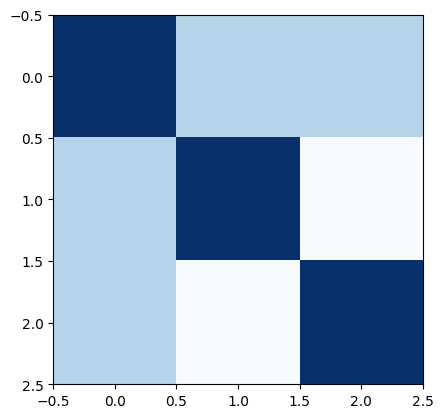

In [238]:
# similarity = 1- distance
# distance_mtx = squareform(pdist(utility, 'cosine'))
# similarity_mtx = 1- distance_mtx

item_similarity = utility.T.corr()
similarity_mtx = item_similarity.to_numpy()

plt.imshow(similarity_mtx, cmap = 'Blues')

In [239]:
similarity_mtx

array([[ 1.        , -0.16666667, -0.16666667],
       [-0.16666667,  1.        , -0.66666667],
       [-0.16666667, -0.66666667,  1.        ]])

In [240]:
# Let's predict the rating of user2 on item 3
user_to_predict = 2
item_to_predict = 1

user2_ratings = utility.iloc[:,user_to_predict-1]
item3_similarity = similarity_mtx[item_to_predict-1]

numerator = np.dot(user2_ratings,item3_similarity)
denom = item3_similarity[user2_ratings > 0].sum()
prediction = numerator / denom
print(prediction)
user2_ratings

5.0


product_id
9     0.0
10    5.0
19    0.0
Name: 2, dtype: float64

In [246]:
def calculate_user_rating(userid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating


def recommendation_to_user(userid, top_n, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = calculate_user_rating(userid, similarity_mtx, utility)

    top_item = sorted(range(1,len(pred_rating)), key = lambda i: -1*pred_rating.iloc[i])
    top_item = list(filter(lambda x: user_rating.iloc[x]==0, top_item))[:top_n]
    res = []
    for i in top_item:
        res.append(tuple([b['id'].index[i-1], pred_rating.iloc[i]]))
    
    return res

recommendation_to_user(3,20,similarity_mtx, utility)

IndexError: single positional indexer is out-of-bounds

In [223]:
import pickle
!mkdir artifacts
pickle.dump(recommendation_to_user, open('artifacts/model.pkl', 'wb'))
pickle.dump(similarity_mtx, open('artifacts/matrix.pkl', 'wb'))
pickle.dump(utility, open('artifacts/utility.pkl', 'wb'))




mkdir: artifacts: File exists
